## Convolutional Neural Network 활용
-----
- CNN을 구성하는 주요 연산을 이해하고, 신경망을 설계한다.
- AlexNet을 사용하여 이미지를 학습하고 10개의 카테고리를 갖는 이미지를 분류하는 이미지 분류기를 생성한다. (데이터셋: [CIFAR](https://pytorch.org/vision/0.9/datasets.html#cifar))
- 이미지 증강을 수행하여 모델의 성능을 높이는 방법을 이해한다.
- Confusion Matrix를 생성하여 분류 정확도를 확인한다.
- **reference**
    - https://tutorials.pytorch.kr/beginner/basics/buildmodel_tutorial.html
    - https://tutorials.pytorch.kr/beginner/basics/data_tutorial.html
    - https://medium.com/@djin31/how-to-plot-wholesome-confusion-matrix-40134fd402a8

# 1번
- 필요한 모듈을 모두 이곳에 나열하세요
- 2점

In [ ]:
# 1. 필요한 모듈을 모두 이곳에 나열하세요
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from torchvision import datasets, models, transforms
from torch.utils.data import DataLoader
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import seaborn as sns

import torchvision
import torchvision.transforms as transforms
import numpy as np

import itertools

# 2번
- CIFAR 데이터(train, test)를 불러오세요
- 2점

In [ ]:
# 2. CIFAR 데이터(train, test)를 불러오세요
train_data = datasets.CIFAR10(
    root='./data',
    train=True,
    download=True,
    transform=transforms.ToTensor()
)

test_set = datasets.CIFAR10(
    root='./data',
    train=False,
    download=True,
    transform=transforms.ToTensor()
)

100%|██████████| 170498071/170498071 [00:13<00:00, 12943955.50it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


# 3번
- 불러온 이미지의 증강을 합니다.
- RandomCrop, RandomHorizontalFlip, Normalize
- Compose 함수를 이용합니다.
- train에는 RandomCrop(28, padding=4), RandomHorizontalFlip, Normalize를 적용한다.
- test에는 Normalize를 적용한다.
- 2점

In [ ]:
# 데이터 전처리 및 증강
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomCrop(32, padding=4),  # CIFAR-10의 이미지 크기에 맞게 32로 수정
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
    ]),
    'test': transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
    ]),
}

In [ ]:
train_data.transform = data_transforms['train']
test_set.transform = data_transforms['test']

# 4번
- Device 설정은 GPU로 합니다
- 2점

In [ ]:
# 4. Device 설정은 GPU
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cuda


# 5번
- train, test의 shape를 확인합니다.
- 2점

In [ ]:
# 5. train, test의 shape
print(train_data.data.shape)
print(test_set.data.shape)

(50000, 32, 32, 3)
(10000, 32, 32, 3)


# 6번
- train, test DataLoader를 만듭니다.
- 배치사이즈: 128
- 2점

In [ ]:
# 6. train, test DataLoader를 만듭니다./ 배치사이즈 128
dataloaders = {
    'train': DataLoader(
        train_data,
        batch_size=128,
        shuffle=True
        ),
    'test': DataLoader(
        test_set,
        batch_size=128,
        shuffle=False
        )
}

# 7번
- train, test의 첫번째 인덱스 데이터를 이미지로 확인합니다.
- 2점

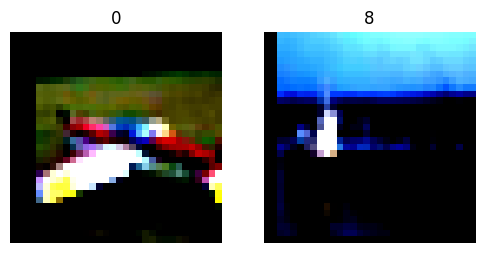

In [ ]:
# 7. train, test의 첫번째 인덱스 데이터를 이미지로 확인

# DataLoader에서 첫 번째 배치 가져오기
batch_train = iter(dataloaders['train'])
batch_test = iter(dataloaders['train'])

# 이미지와 레이블 가져오기
imgs, labels = next(batch_train)
imgs2, labels2 = next(batch_test)

train_img, train_label = imgs[0], labels[0]
test_img, test_label = imgs2[0], labels2[0]

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(6, 4))

# 이미지 시각화
axes[0].imshow(train_img.permute(1, 2, 0))
axes[0].set_title(str(train_label.item()))
axes[0].axis('off')

axes[1].imshow(test_img.permute(1, 2, 0))
axes[1].set_title(str(test_label.item()))
axes[1].axis('off')

plt.show()

# 8번
- CIFAR의 클래스를 labels_map 이름의 딕셔너리로 생성합니다.
- 2점

In [ ]:
# 8. CIFAR의 클래스를 labels_map 이름의 딕셔너리로 생성
labels_map = {
    0: 'airplane',
    1: 'car',
    2: 'bird',
    3: 'cat',
    4: 'deer',
    5: 'dog',
    6: 'frog',
    7: 'horse',
    8: 'ship',
    9: 'truck'
}

# 딕셔너리 확인
print(labels_map)

{0: 'airplane', 1: 'car', 2: 'bird', 3: 'cat', 4: 'deer', 5: 'dog', 6: 'frog', 7: 'horse', 8: 'ship', 9: 'truck'}


# 9번
- 5행 5열로 train 데이터를 이미지로 출력합니다.
- labels_map를 이용하여 이미지의 label도 함께 출력합니다.
- 2점

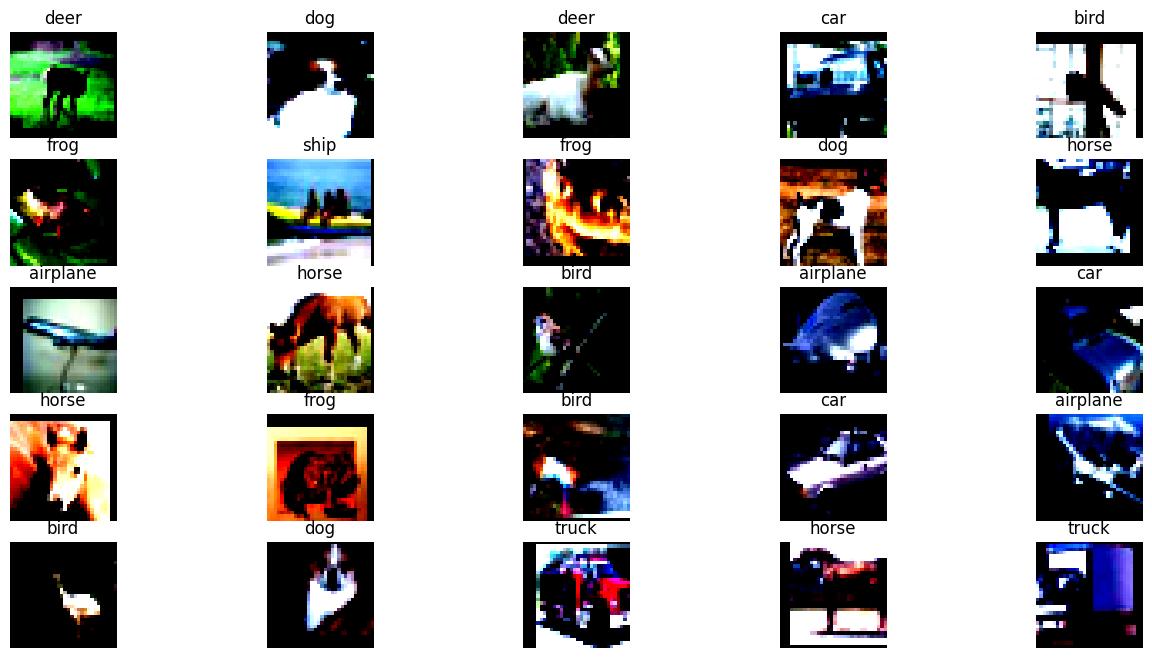

In [ ]:
# 9. 5행 5열로 train 데이터를 이미지로 출력/ labels_map를 이용하여 이미지의 label도 함께 출력
imgs, labels = next(iter(dataloaders['train']))

fig, axes = plt.subplots(5, 5, figsize=(16, 8))

for ax, img, label in zip(axes.flatten(), imgs, labels):
    ax.imshow(img.permute(1, 2, 0))
    ax.set_title(labels_map[label.item()])
    ax.axis('off')

# 10번
- AlexNet(https://en.wikipedia.org/wiki/File:Comparison_image_neural_networks.svg)
- 위 모델을 참조하여 class를 만듭니다.
- 2점

In [ ]:
# 10. AlexNet 코드
class AlexNet(nn.Module):
    def __init__(self, num_classes=10):
        super(AlexNet, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        self.classifier = nn.Sequential(
            nn.Dropout(),
            nn.Linear(512 * 4 * 4, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Linear(4096, num_classes),
        )
    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x

# 11번
- 인공신경망 객체를 GPU에 저장합니다.
- 3점

In [ ]:
# 인공신경망 객체를 GPU에 저장
model = AlexNet().to(device)
print(model)

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=8192, out_features=4096, bias=True)
    (2): ReLU(inplace=True)
    (3): Dropout(p=0.5, inplace=False)
    (4): Linear(in_features=4096, out_features=4096, bias=True)
    (5): ReLU(inplace=True)
  

# 12번
- Loss 함수를 정의합니다.
- 학습률을 0.001로 설정합니다.
- 옵티마이저는 Adam을 사용합니다.
- 3점

In [ ]:
# 12. Loss 함수를 정의
loss = nn.CrossEntropyLoss()
# 학습률을 0.001
LEARNING_RATE = 1e-3
# 옵티마이저는 Adam
optimizer = torch.optim.Adam(model.parameters(), lr = LEARNING_RATE)

print(loss)
print(optimizer)

CrossEntropyLoss()
Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 0.001
    maximize: False
    weight_decay: 0
)


# 13번
- 학습 함수를 train_loop로 작성합니다.
- 매개변수(데이터로더, 모델, loss 함수, 옵티마이저)
- 데이터로더의 인덱스가 배치사이즈마다 loss를 출력합니다.
- 3점

In [ ]:
def train_loop(dataloader, model, criterion, optimizer):
    model.train()
    size = len(dataloader.dataset)
    for batch_idx, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)
        pred = model(X)
        loss = criterion(pred, y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    print(f"loss: {loss.item():>2f}  [{batch_idx * len(X):>5d}/{size:>5d}]")

# 14번
- 테스트 함수를 test_loop로 작성합니다.
- 매개변수(데이터로더, 모델, loss 함수)
- 데이터로더의 크기만큼 반복하며 loss를 출력하고 전체 accuracy와 평균 loss를 구합니다.
- 3점

In [ ]:
def test_loop(dataloader, model, criterion):
    model.eval()
    size = len(dataloader.dataset)
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += criterion(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    test_loss /= len(dataloader)
    accuracy = correct / size
    print(f"Test Error: Accuracy: {(100*accuracy):>0.1f}%, Avg loss: {test_loss:>2f}")

# 15번
- 100번의 epochs를 돌며 학습을 반복합니다.
- 3점

In [ ]:
num_epochs = 100
for epoch in range(num_epochs):
    print(f'Epoch {epoch+1}/{num_epochs}')
    # 학습
    train_loop(dataloaders['train'], model, loss, optimizer)
    # 테스트
    test_loop(dataloaders['test'], model, loss)
    # 에포크 간의 구분 출력
    print('-' * 50)

Epoch 1/100
loss: 1.334871  [31200/50000]
Test Error: Accuracy: 51.2%, Avg loss: 1.315063
--------------------------------------------------
Epoch 2/100
loss: 1.096192  [31200/50000]
Test Error: Accuracy: 62.3%, Avg loss: 1.032144
--------------------------------------------------
Epoch 3/100
loss: 1.125641  [31200/50000]
Test Error: Accuracy: 65.8%, Avg loss: 0.965257
--------------------------------------------------
Epoch 4/100
loss: 0.829248  [31200/50000]
Test Error: Accuracy: 68.4%, Avg loss: 0.880596
--------------------------------------------------
Epoch 5/100
loss: 0.822386  [31200/50000]
Test Error: Accuracy: 70.8%, Avg loss: 0.822126
--------------------------------------------------
Epoch 6/100
loss: 0.900101  [31200/50000]
Test Error: Accuracy: 72.6%, Avg loss: 0.777023
--------------------------------------------------
Epoch 7/100
loss: 0.937042  [31200/50000]
Test Error: Accuracy: 74.1%, Avg loss: 0.748406
--------------------------------------------------
Epoch 8/100
l

# 16번
- 사이킷런의 confusion_matrix를 활용해 학습된 결과에 대해 분석합니다.
- 분석한 결과를 간단히 서술합니다.
- 3점

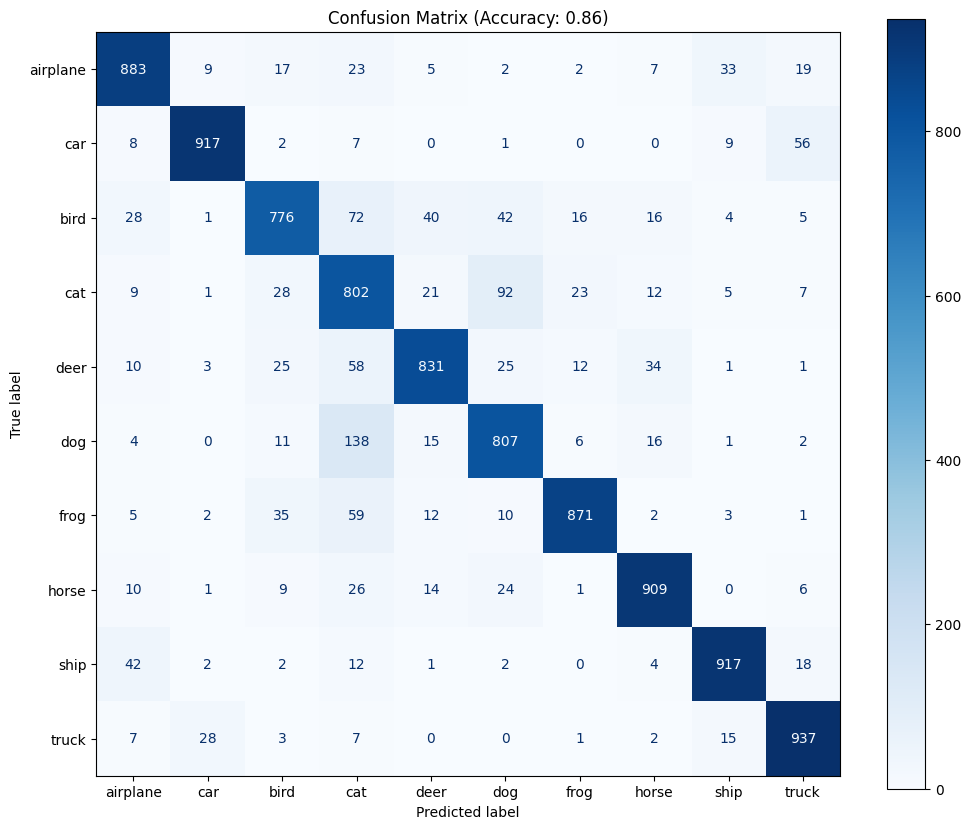

In [ ]:
# 모델을 평가 모드로 설정
model.eval()

# 데이터 수집을 위한 빈 리스트 생성
all_labels = []
all_predictions = []

# 테스트 데이터 로더를 통해 반복
with torch.no_grad():
    for inputs, labels in dataloaders['test']:
        # 데이터를 디바이스로 이동
        inputs, labels = inputs.to(device), labels.to(device)
        # 모델을 통해 예측 수행
        outputs = model(inputs)
        _, predictions = torch.max(outputs, 1)
        # 라벨과 예측 결과를 리스트에 추가
        all_labels.extend(labels.cpu().numpy())
        all_predictions.extend(predictions.cpu().numpy())

# 리스트를 numpy 배열로 변환
test_labels = np.array(all_labels)
test_predictions = np.array(all_predictions)

# 혼동 행렬 계산
cm = confusion_matrix(test_labels, test_predictions)

# 혼동 행렬 시각화
fig, ax = plt.subplots(figsize=(12, 10))  # 크기 조정
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=list(labels_map.values()))
disp.plot(cmap=plt.cm.Blues, values_format='d', ax=ax)
plt.title(f'Confusion Matrix (Accuracy: {accuracy:.2f})')
plt.show()

#분석 결과

1. 전체 정확도:
    * 모델의 전체 정확도는 86%로 나타났다.
    * 이는 모델이 10개의 클래스 중 약 86%를 올바르게 분류했다는 것을 의미한다.

2. 클래스별 정확도:
    * airplane: 88.3%
    * car: 91.7%
    * bird: 77.6%
    * cat: 80.2%
    * deer: 83.1%
    * dog: 80.7%
    * frog: 87.1%
    * horse: 90.9%
    * ship: 91.7%
    * truck: 93.7%

3. 오류 분석:
    * bird 클래스는 cat, deer, dog 등 다른 클래스와의 혼동이 많아 정확도가 77.6%로 낮다.
    * dog 클래스는 cat과 deer와의 혼동이 많아 정확도가 80.7%로 비교적 낮다.
    * ship 클래스는 airplane 클래스와의 혼동이 많아 정확도가 91.7%로 조금 낮아졌다

4. 주요 혼동:
    * bird와 cat 간의 혼동이 비교적 많다.
    * deer와 cat 간의 혼동이 많다.

5. 결론:
    * 모델은 대부분의 클래스를 잘 분류하지만, 특정 클래스(특히 bird와 cat) 간의 혼동이 있다.
    * 이를 개선하기 위해 데이터 증강 기법을 추가로 적용하거나, 모델 아키텍처를 조정하는 등의 추가적인 노력이 필요할 수도 있다.

In [ ]:
# 혼동 행렬 계산
cm = confusion_matrix(test_labels, test_predictions)
# 클래스 수
num_classes = cm.shape[0]
# TP, FP, FN, TN을 저장할 리스트
tp = np.zeros(num_classes)
fp = np.zeros(num_classes)
fn = np.zeros(num_classes)
tn = np.zeros(num_classes)
for i in range(num_classes):
    tp[i] = cm[i, i]  # 대각선의 값이 TP
    fp[i] = np.sum(cm[:, i]) - tp[i]  # 열에서 해당 클래스의 값을 제외한 값이 FP
    fn[i] = np.sum(cm[i, :]) - tp[i]  # 행에서 해당 클래스의 값을 제외한 값이 FN
    tn[i] = np.sum(cm) - (tp[i] + fp[i] + fn[i])  # 전체에서 TP, FP, FN을 제외한 값이 TN
# 결과 출력
for i in range(num_classes):
    print(f"Class {i}:")
    print(f"  True Positive (TP): {tp[i]}")
    print(f"  False Positive (FP): {fp[i]}")
    print(f"  False Negative (FN): {fn[i]}")
    print(f"  True Negative (TN): {tn[i]}")
    print()

Class 0:
  True Positive (TP): 883.0
  False Positive (FP): 123.0
  False Negative (FN): 117.0
  True Negative (TN): 8877.0

Class 1:
  True Positive (TP): 917.0
  False Positive (FP): 47.0
  False Negative (FN): 83.0
  True Negative (TN): 8953.0

Class 2:
  True Positive (TP): 776.0
  False Positive (FP): 132.0
  False Negative (FN): 224.0
  True Negative (TN): 8868.0

Class 3:
  True Positive (TP): 802.0
  False Positive (FP): 402.0
  False Negative (FN): 198.0
  True Negative (TN): 8598.0

Class 4:
  True Positive (TP): 831.0
  False Positive (FP): 108.0
  False Negative (FN): 169.0
  True Negative (TN): 8892.0

Class 5:
  True Positive (TP): 807.0
  False Positive (FP): 198.0
  False Negative (FN): 193.0
  True Negative (TN): 8802.0

Class 6:
  True Positive (TP): 871.0
  False Positive (FP): 61.0
  False Negative (FN): 129.0
  True Negative (TN): 8939.0

Class 7:
  True Positive (TP): 909.0
  False Positive (FP): 93.0
  False Negative (FN): 91.0
  True Negative (TN): 8907.0

Class

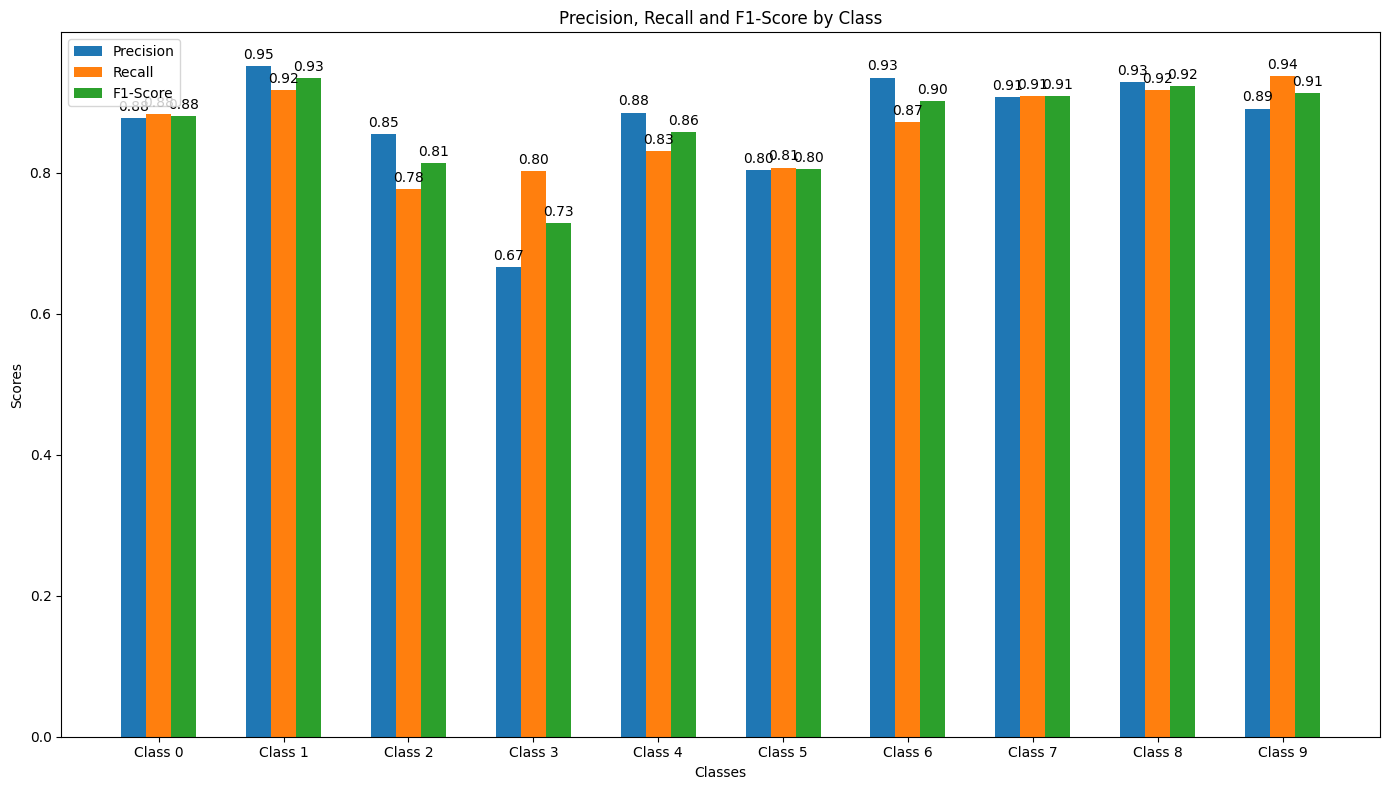

In [ ]:
# 클래스별 값 정의
classes = [f'Class {i}' for i in range(10)]
TP = [883, 917, 776, 802, 831, 807, 871, 909, 917, 937]
FP = [123, 47, 132, 402, 108, 198, 61, 93, 71, 115]
FN = [117, 83, 224, 198, 169, 193, 129, 91, 83, 63]
TN = [8877, 8953, 8868, 8598, 8892, 8802, 8939, 8907, 8929, 8885]

# Precision, Recall, F1-Score 계산
precision = [TP[i] / (TP[i] + FP[i]) for i in range(10)]
recall = [TP[i] / (TP[i] + FN[i]) for i in range(10)]
f1_score = [2 * (precision[i] * recall[i]) / (precision[i] + recall[i]) for i in range(10)]

# 그래프 그리기
x = np.arange(len(classes))
width = 0.2

fig, ax = plt.subplots(figsize=(14, 8))

rects1 = ax.bar(x - width, precision, width, label='Precision')
rects2 = ax.bar(x, recall, width, label='Recall')
rects3 = ax.bar(x + width, f1_score, width, label='F1-Score')

# 그래프에 라벨 추가
ax.set_xlabel('Classes')
ax.set_ylabel('Scores')
ax.set_title('Precision, Recall and F1-Score by Class')
ax.set_xticks(x)
ax.set_xticklabels(classes)
ax.legend()

# 막대 위에 값 표시
def autolabel(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate(f'{height:.2f}',
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

autolabel(rects1)
autolabel(rects2)
autolabel(rects3)

fig.tight_layout()
plt.show()

# 결론

* Precision: 모델이 특정 클래스를 Positive로 예측한 경우, 실제로도 Positive일 확률을 나타냅니다. 예를 들어, Class 1 (car)의 Precision이 95.12%로 매우 높아, 모델이 car로 예측한 경우 대부분 정확하다는 것을 의미합니다.

* Recall: 실제 Positive인 경우를 모델이 얼마나 잘 찾아내는지를 나타냅니다. Class 9 (truck)의 Recall이 93.70%로 매우 높아, 실제 truck인 경우 대부분 모델이 잘 예측한다는 것을 의미합니다.

* F1-Score: Precision과 Recall의 조화 평균으로, 두 값의 균형을 잘 나타냅니다. Class 1 (car)의 F1-Score가 93.36%로 매우 높아, 모델이 car를 매우 잘 예측한다는 것을 의미합니다.

* 모델은 대부분의 클래스에서 높은 Precision과 Recall을 보이며, 특히 car, frog, horse, ship 클래스에서 매우 높은 성능을 보입니다. 그러나 bird와 cat 클래스에서는 상대적으로 낮은 성능을 보여, 이를 개선하기 위한 추가적인 노력이 필요합니다.

# 17번
- 학습된 파라미터를 저장합니다.
- 파일명은 model_weights.pth로 합니다.
- 3점

In [ ]:
# 학습된 파라미터를 저장
torch.save(model.state_dict(), "model_weights.pth")
print("Model weights saved to model_weights.pth")

Model weights saved to model_weights.pth


# 18번
- 새로운 인공신경망을 GPU에 만들고 위 학습된 파일(model_weights.pth)을 불러옵니다.
- 3점

In [ ]:
# 새로운 모델 인스턴스 생성 및 GPU로 이동
new_model = AlexNet(num_classes=10).to(device)

# 학습된 파라미터 불러오기
new_model.load_state_dict(torch.load("model_weights.pth"))
print("Model weights loaded from model_weights.pth")
print(new_model)

# 새로운 모델로 테스트 데이터 결과 확인
test_loop(dataloaders['test'], new_model, loss)

Model weights loaded from model_weights.pth
AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=8192, out_features=4096, bias=True)
    (2): ReLU(inplace=True)
    (3): Dropout(p=0.5, inplace=False)
    (4): Linear(in_features=4096, out_features=409

# 19번
- 위 모델에 test 데이터로더를 입력하고 결과를 확인합니다.
- 3점

In [ ]:
# Accuracy 계산 및 출력
accuracy = np.sum(test_labels == test_predictions) / len(test_labels) * 100
print(f'Accuracy: {accuracy:.2f}%')
# 테스트 데이터에서 첫 배치 가져오기
inputs, labels = next(iter(dataloaders['test']))
# 모델의 예측 수행
inputs, labels = inputs.to(device), labels.to(device)
outputs = new_model(inputs)
_, predictions = torch.max(outputs, 1)

Accuracy: 86.50%


# 20번
- 5행 5열로 test 데이터를 이미지로 출력합니다.
- 학습된 모델이 분류기가 잘 작동하는지 label과 예측된 결과를 동시에 출력합니다.
- 3점

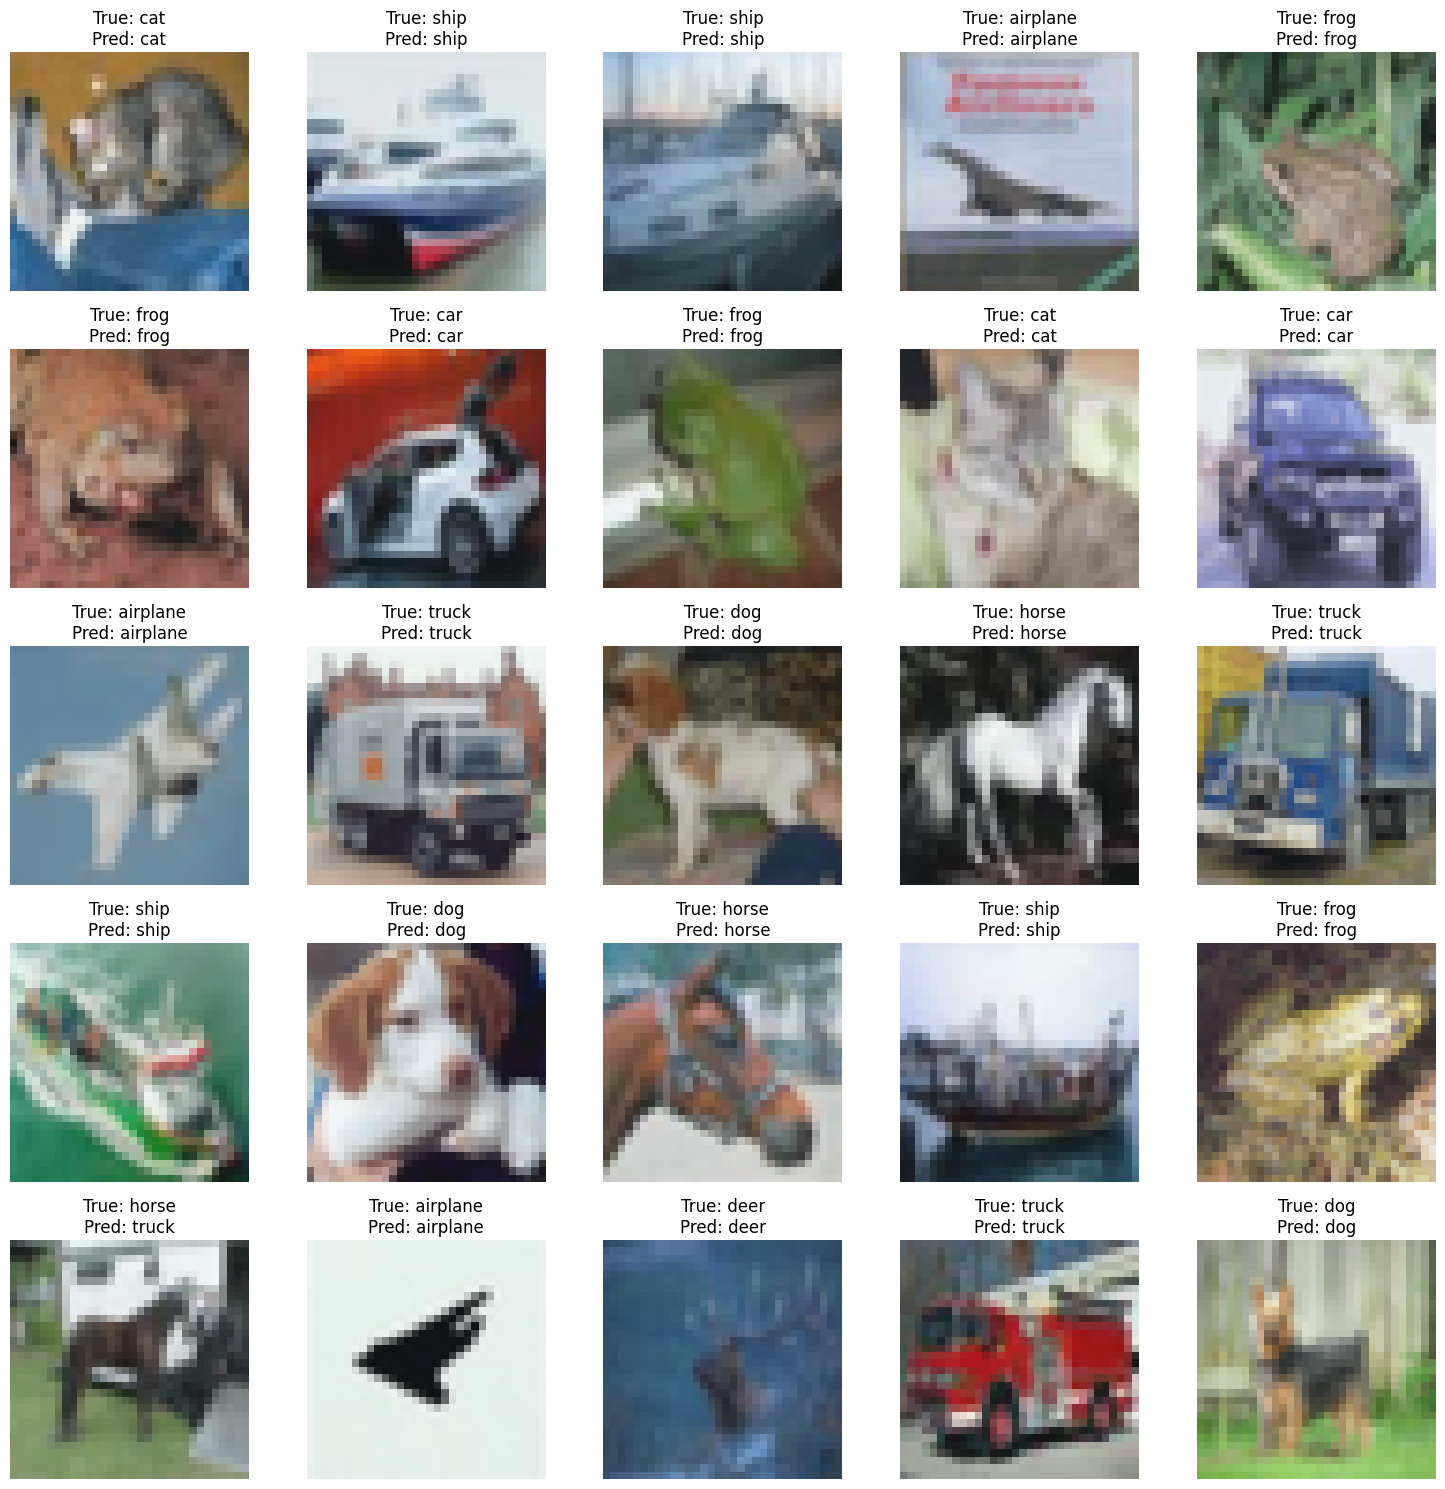

In [ ]:
# 5x5 그리드로 테스트 데이터 출력 및 예측 결과 표시
fig, axes = plt.subplots(5, 5, figsize=(15, 15))
axes = axes.flatten()
for img, label, pred, ax in zip(images.cpu(), labels.cpu(), preds.cpu(), axes):
    img = img.permute(1, 2, 0)  # 채널 차원을 마지막으로 이동
    img = img * torch.tensor([0.2023, 0.1994, 0.2010]) + torch.tensor([0.4914, 0.4822, 0.4465])  # 정규화 해제
    img = img.numpy()
    ax.imshow(img)
    ax.set_title(f"True: {labels_map[label.item()]}\nPred: {labels_map[pred.item()]}")
    ax.axis('off')

plt.tight_layout()
plt.show()